In [1]:
 !pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00


In [76]:
import google_play_scraper

In [77]:
app_id = 'com.Version1'

In [78]:
from google_play_scraper import Sort
from google_play_scraper.constants.element import ElementSpecs
from google_play_scraper.constants.regex import Regex
from google_play_scraper.constants.request import Formats
from google_play_scraper.utils.request import post

In [79]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import time
import json
from time import sleep
from typing import List, Optional, Tuple

In [80]:
MAX_COUNT_EACH_FETCH = 199


class _ContinuationToken:
    __slots__ = (
        "token",
        "lang",
        "country",
        "sort",
        "count",
        "filter_score_with",
        "filter_device_with",
    )

    def __init__(
        self, token, lang, country, sort, count, filter_score_with, filter_device_with
    ):
        self.token = token
        self.lang = lang
        self.country = country
        self.sort = sort
        self.count = count
        self.filter_score_with = filter_score_with
        self.filter_device_with = filter_device_with

In [81]:
def _fetch_review_items(
    url: str,
    app_id: str,
    sort: int,
    count: int,
    filter_score_with: Optional[int],
    filter_device_with: Optional[int],
    pagination_token: Optional[str],
):
    dom = post(
        url,
        Formats.Reviews.build_body(
            app_id,
            sort,
            count,
            "null" if filter_score_with is None else filter_score_with,
            "null" if filter_device_with is None else filter_device_with,
            pagination_token,
        ),
        {"content-type": "application/x-www-form-urlencoded"},
    )
    match = json.loads(Regex.REVIEWS.findall(dom)[0])

    return json.loads(match[0][2])[0], json.loads(match[0][2])[-2][-1]

In [82]:
def reviews(
    app_id: str,
    lang: str = "en",
    country: str = "us",
    sort: Sort = Sort.MOST_RELEVANT,
    count: int = 100,
    filter_score_with: int = None,
    filter_device_with: int = None,
    continuation_token: _ContinuationToken = None,
) -> Tuple[List[dict], _ContinuationToken]:
    sort = sort.value

    if continuation_token is not None:
        token = continuation_token.token

        if token is None:
            return (
                [],
                continuation_token,
            )

        lang = continuation_token.lang
        country = continuation_token.country
        sort = continuation_token.sort
        count = continuation_token.count
        filter_score_with = continuation_token.filter_score_with
        filter_device_with = continuation_token.filter_device_with
    else:
        token = None

    url = Formats.Reviews.build(lang=lang, country=country)

    _fetch_count = count

    result = []

    while True:
        if _fetch_count == 0:
            break

        if _fetch_count > MAX_COUNT_EACH_FETCH:
            _fetch_count = MAX_COUNT_EACH_FETCH

        try:
            review_items, token = _fetch_review_items(
                url,
                app_id,
                sort,
                _fetch_count,
                filter_score_with,
                filter_device_with,
                token,
            )
        except (TypeError, IndexError):
            #funnan MOD start
            token = continuation_token.token
            continue
            #MOD end

        for review in review_items:
            result.append(
                {
                    k: spec.extract_content(review)
                    for k, spec in ElementSpecs.Review.items()
                }
            )

        _fetch_count = count - len(result)

        if isinstance(token, list):
            token = None
            break

    return (
        result,
        _ContinuationToken(
            token, lang, country, sort, count, filter_score_with, filter_device_with
        ),
    )


In [83]:
def reviews_all(app_id: str, sleep_milliseconds: int = 0, **kwargs) -> list:
    kwargs.pop("count", None)
    kwargs.pop("continuation_token", None)

    continuation_token = None

    result = []

    while True:
        _result, continuation_token = reviews(
            app_id,
            count=MAX_COUNT_EACH_FETCH,
            continuation_token=continuation_token,
            **kwargs
        )

        result += _result

        if continuation_token.token is None:
            break

        if sleep_milliseconds:
            sleep(sleep_milliseconds / 1000)

    return result

In [84]:
reviews_count = 10000

In [61]:
result = []
continuation_token = None


with tqdm(total=reviews_count, position=0, leave=True) as pbar:
    while len(result) < reviews_count:
        new_result, continuation_token = reviews(
            app_id,
            continuation_token=continuation_token,
            lang='en', #The language of review
            country='in', #Country for which you want to scrape
            sort=Sort.NEWEST,
            filter_score_with=None,
            count=199 #No need to change this
        )
        if not new_result:
            break
        result.extend(new_result)
        pbar.update(len(new_result))

10149it [00:12, 814.45it/s]


In [62]:
import pandas as pd

def set_frame_style(df):
    # Add your styling logic here
    return df  # Or modify and return the styled DataFrame

df = pd.DataFrame(result)

set_frame_style(df.head(5))

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,454a3f03-2fc0-49cf-a696-249a2a5f04e5,Partha Gantait,https://play-lh.googleusercontent.com/a-/ALV-U...,"Frustrated, just frustated",1,0,2.43,2024-08-05 10:01:00,"Dear Partha, thank you for your feedback. We'r...",2024-08-05 10:07:38,2.43
1,d21d3cc7-2099-4eb0-8d32-303c136b661d,Animesh Biswas,https://play-lh.googleusercontent.com/a/ACg8oc...,Worst bank & their worst castomer service . If...,1,0,None,2024-08-05 09:58:48,"Dear Animesh, We apologize for the inconvenien...",2024-08-05 10:07:15,None
2,97adedaa-d164-4658-8742-f49047072de9,sujeet singh,https://play-lh.googleusercontent.com/a-/ALV-U...,Not bad,4,0,2.42,2024-08-05 09:57:28,"Dear Sujeet, thank you for your support. We co...",2024-08-05 10:18:47,2.42
3,e2b1becd-e89d-4096-aafe-add899af8672,Akash Das,https://play-lh.googleusercontent.com/a-/ALV-U...,Good,5,0,2.43,2024-08-05 09:56:08,"Dear Akash, we're incredibly grateful for your...",2024-08-05 10:04:32,2.43
4,51189d2e-14fe-44c5-a379-cbe87098fdcf,Shailendra Raghav,https://play-lh.googleusercontent.com/a-/ALV-U...,Good pnb one aap sabse bhatreen aap,5,0,2.43,2024-08-05 09:55:45,"Dear Shailendra, we're incredibly grateful for...",2024-08-05 10:04:07,2.43


In [64]:
df.columns

Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')

In [65]:
df = df[['reviewId', 'userName', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'appVersion']]

In [66]:
import datetime

In [67]:
today = datetime.date.today()

yesterday = today - datetime.timedelta(days=1)

print(yesterday)

2024-08-05


In [68]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,454a3f03-2fc0-49cf-a696-249a2a5f04e5,Partha Gantait,"Frustrated, just frustated",1,0,2.43,2024-08-05 10:01:00,2.43
1,d21d3cc7-2099-4eb0-8d32-303c136b661d,Animesh Biswas,Worst bank & their worst castomer service . If...,1,0,None,2024-08-05 09:58:48,None
2,97adedaa-d164-4658-8742-f49047072de9,sujeet singh,Not bad,4,0,2.42,2024-08-05 09:57:28,2.42
3,e2b1becd-e89d-4096-aafe-add899af8672,Akash Das,Good,5,0,2.43,2024-08-05 09:56:08,2.43
4,51189d2e-14fe-44c5-a379-cbe87098fdcf,Shailendra Raghav,Good pnb one aap sabse bhatreen aap,5,0,2.43,2024-08-05 09:55:45,2.43


In [69]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1yYRU2lDL-ds51POb98MgHvo6wKQs51uWtzrXMuqdpec#gid=0


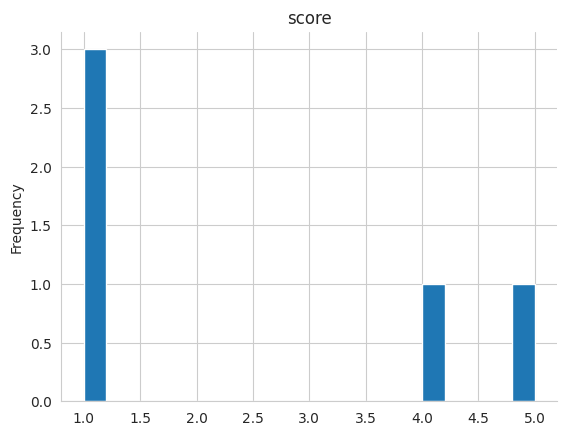

In [70]:
from matplotlib import pyplot as plt
_df_0['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [71]:
df['at'].iloc[0].date()

datetime.date(2024, 8, 5)

In [72]:
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,454a3f03-2fc0-49cf-a696-249a2a5f04e5,Partha Gantait,"Frustrated, just frustated",1,0,2.43,2024-08-05 10:01:00,2.43
1,d21d3cc7-2099-4eb0-8d32-303c136b661d,Animesh Biswas,Worst bank & their worst castomer service . If...,1,0,None,2024-08-05 09:58:48,None
2,97adedaa-d164-4658-8742-f49047072de9,sujeet singh,Not bad,4,0,2.42,2024-08-05 09:57:28,2.42
3,e2b1becd-e89d-4096-aafe-add899af8672,Akash Das,Good,5,0,2.43,2024-08-05 09:56:08,2.43
4,51189d2e-14fe-44c5-a379-cbe87098fdcf,Shailendra Raghav,Good pnb one aap sabse bhatreen aap,5,0,2.43,2024-08-05 09:55:45,2.43
...,...,...,...,...,...,...,...,...
10144,0275a806-bd3b-494f-b424-ed6b36c74973,xavier paulraj,Friendly.,5,0,2.42,2024-07-08 13:06:00,2.42
10145,16e915ce-85e6-42fa-b03e-4b8ceffcaade,Rahul Agarwal,Bank app is very good. Easy to use. Recommend ...,5,0,2.42,2024-07-08 13:00:53,2.42
10146,32adb60d-8b20-4788-9c2b-0d2817933a95,Laily Roy,Very nice.service of staff are remarkable.mana...,5,0,2.42,2024-07-08 13:00:14,2.42
10147,1316e463-03a5-441d-9cb8-c61dd5c8027d,Shahin Ansari,Excellent,5,0,2.42,2024-07-08 12:57:34,2.42


In [74]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1GFzKmMooglF8jfRBddHyavKRIQu2DO7eXJJagmOuTs8#gid=0


In [75]:
new_df = df[df['at'].dt.date == yesterday]

In [25]:
new_df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,88a06742-164b-4b2c-a5f1-790a96cbd683,Ashish Sharma,Your last season incorrectly terminated or act...,1,0,11.2.3,2024-08-05 09:08:26,11.2.3
1,a8375493-d9a4-40ff-8ff0-544b55c99f00,rajeev bhardwaj,Horrible experience with this bank.. All emplo...,1,0,11.2.3,2024-08-05 09:06:29,11.2.3
2,d90ffe93-0ef9-4bea-b9e4-a5231c3b9d47,Swapnali Ingale,Useless. Not able to login since last 2-3 days,1,0,11.2.3,2024-08-05 08:52:28,11.2.3
3,d806a3ec-306e-41b3-83b0-0997f62025f7,Mantu Yadav,Nice and good,5,0,11.2.3,2024-08-05 08:50:28,11.2.3
4,ac74b376-f9ec-48fb-b4c6-51dc15e0834b,Sagar Mane,Runs good and Smoorth,4,0,11.2.3,2024-08-05 08:49:31,11.2.3


In [85]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=new_df)

https://docs.google.com/spreadsheets/d/1tb7nXiXjk6k3PdqdfIn9HW40FHznbwwz5Z2gERSUCmk#gid=0


In [86]:
import os

In [87]:
# prompt: create a directory of my data

!mkdir my_data


mkdir: cannot create directory ‘my_data’: File exists


In [88]:
import pandas as pd

# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'pnbbank.csv'

dataset = pd.read_csv(file_path)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              164 non-null    object 
 1   userName              164 non-null    object 
 2   content               164 non-null    object 
 3   score                 164 non-null    int64  
 4   thumbsUpCount         164 non-null    int64  
 5   reviewCreatedVersion  140 non-null    float64
 6   at                    164 non-null    object 
 7   appVersion            140 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 10.4+ KB


In [89]:
if 'Unnamed: 0' in dataset.columns :
    dataset = dataset.drop('Unnamed: 0', axis = 1)

dataset.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,454a3f03-2fc0-49cf-a696-249a2a5f04e5,Partha Gantait,"Frustrated, just frustated",1,0,2.43,2024-08-05T10:01:00,2.43
1,d21d3cc7-2099-4eb0-8d32-303c136b661d,Animesh Biswas,Worst bank & their worst castomer service . If...,1,0,NaN,2024-08-05T09:58:48,NaN
2,97adedaa-d164-4658-8742-f49047072de9,sujeet singh,Not bad,4,0,2.42,2024-08-05T09:57:28,2.42
3,e2b1becd-e89d-4096-aafe-add899af8672,Akash Das,Good,5,0,2.43,2024-08-05T09:56:08,2.43
4,51189d2e-14fe-44c5-a379-cbe87098fdcf,Shailendra Raghav,Good pnb one aap sabse bhatreen aap,5,0,2.43,2024-08-05T09:55:45,2.43


In [93]:
new_df = pd.concat([new_df,dataset], axis = 0)
new_df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,454a3f03-2fc0-49cf-a696-249a2a5f04e5,Partha Gantait,"Frustrated, just frustated",1,0,2.43,2024-08-05 10:01:00,2.43
1,d21d3cc7-2099-4eb0-8d32-303c136b661d,Animesh Biswas,Worst bank & their worst castomer service . If...,1,0,None,2024-08-05 09:58:48,None
2,97adedaa-d164-4658-8742-f49047072de9,sujeet singh,Not bad,4,0,2.42,2024-08-05 09:57:28,2.42
3,e2b1becd-e89d-4096-aafe-add899af8672,Akash Das,Good,5,0,2.43,2024-08-05 09:56:08,2.43
4,51189d2e-14fe-44c5-a379-cbe87098fdcf,Shailendra Raghav,Good pnb one aap sabse bhatreen aap,5,0,2.43,2024-08-05 09:55:45,2.43


In [94]:
new_df.to_csv('pnbbank.csv', index = False)

In [95]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 492 entries, 0 to 163
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              492 non-null    object
 1   userName              492 non-null    object
 2   content               492 non-null    object
 3   score                 492 non-null    int64 
 4   thumbsUpCount         492 non-null    int64 
 5   reviewCreatedVersion  420 non-null    object
 6   at                    492 non-null    object
 7   appVersion            420 non-null    object
dtypes: int64(2), object(6)
memory usage: 50.8+ KB


In [104]:
new_df['at'] = pd.to_datetime(new_df['at'])

In [105]:
new_df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,year_month
0,454a3f03-2fc0-49cf-a696-249a2a5f04e5,Partha Gantait,"Frustrated, just frustated",1,0,2.43,2024-08-05 10:01:00,2.43,2024-08
1,d21d3cc7-2099-4eb0-8d32-303c136b661d,Animesh Biswas,Worst bank & their worst castomer service . If...,1,0,None,2024-08-05 09:58:48,None,2024-08
2,97adedaa-d164-4658-8742-f49047072de9,sujeet singh,Not bad,4,0,2.42,2024-08-05 09:57:28,2.42,2024-08
3,e2b1becd-e89d-4096-aafe-add899af8672,Akash Das,Good,5,0,2.43,2024-08-05 09:56:08,2.43,2024-08
4,51189d2e-14fe-44c5-a379-cbe87098fdcf,Shailendra Raghav,Good pnb one aap sabse bhatreen aap,5,0,2.43,2024-08-05 09:55:45,2.43,2024-08


In [106]:
new_df['year_month'] = new_df['at'].dt.to_period('M')
new_df = new_df[new_df['year_month'].dt.year >= 2019]
new_df_grouped = new_df.groupby('year_month')['score'].mean()

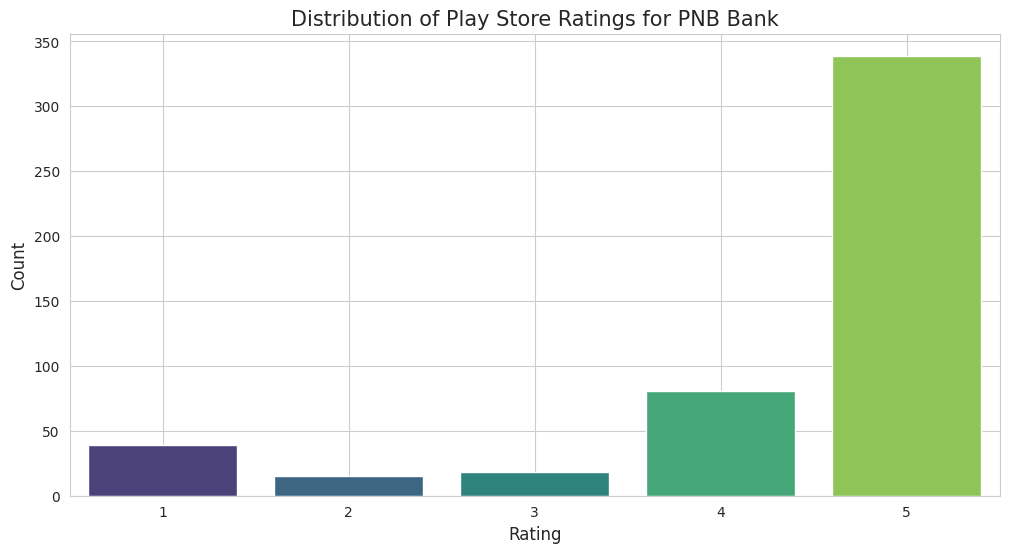

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = 'pnbbank.csv'
df = pd.read_csv(file_path)

# Assuming 'score' column contains the ratings (1-5)
plt.figure(figsize=(12, 6))
sns.countplot(x='score', data=df, palette='viridis')
plt.title('Distribution of Play Store Ratings for PNB Bank', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)  # Add grid for better readability
plt.show()
